In [131]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mutual_info_score, accuracy_score, auc
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression, Ridge


from matplotlib.collections import EllipseCollection
from matplotlib.colors import Normalize

# Data preprocessing


- Keep only the columns above
- Lowercase the column names and replace spaces with underscores
- Fill the missing values with 0
- Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable above_avg
- Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [132]:
df = pd.read_csv('Data/car_price.csv')


In [133]:
# Feature selection
features = ['Make', 'Model', 'Year', 'Engine HP',
            'Engine Cylinders', 'Transmission Type', 'Vehicle Style',
            'highway MPG', 'city mpg', 'MSRP']

df = df[features]

# lowercase for columns names and replace spaces
df.columns = df.columns.str.lower()\
                           .str.replace(' ','_')

# Missing values
# Rename target column and fill missing values with zero
df.rename(columns= {'msrp':'price'}, inplace = True)
df[['engine_hp', 'engine_cylinders']] = df[['engine_hp', 'engine_cylinders']].fillna(0)

# Making numerical variables binary
avg_price = df['price'].mean()
above_avg = df['price'] > avg_price

# Binary variables: if above average
#1: True
#0: False
df['above_avg'] = above_avg.astype(int)

display(df[['price', 'above_avg']].head())
print('Average:', round(avg_price, 0))

df.head(2)

# delete price 
del df['price']

,price,above_avg
0,46135,1
1,40650,1
2,36350,0
3,29450,0
4,34500,0


Average: 40595.0


In [134]:
# Split data : 100% -> 1*(1 - 0.2) = 0.8/ 1*0.2 = 0.2
df_full_train, df_test = train_test_split(df, test_size = 0.2,  random_state=1)
# Split again : 80% -> 0.8(1 - 0.25) = 0.6/ 0.8*0.25 = 0.2 
df_train, df_val = train_test_split(df_full_train, test_size = 0.25,  random_state=1)

# save target values
Y_train = df_train['above_avg'].values
Y_val = df_val['above_avg'].values

# take out the target values from the dataframe
del df_train['above_avg']
del df_val['above_avg']

# Model Evaluation

Process of determining how well your machine learning model performs against some criteria

## **Confusion Matrix for Binary classes**

Consider a hypothetical dataset with multiple features $\mathbf{X}_{1},\cdots, \mathbf{X}_{d}$ and a target variable $\mathbf{Y}$ as shown:

$$
\left( \begin{array}{c|ccc|c}
\text{Instance}    &\mathbf{X}_{1}&\cdots & \mathbf{X}_{d}  & \mathbf{Y}\\
\hline
\mathbf{x}_{1} & x_{11}& \cdots&x_{1d}&y_1 \\
\vdots&\vdots&\ddots&\vdots&\vdots\\
\mathbf{x}_{n}&x_{n1}&\cdots&x_{nd}&y_n
\end{array} \right).$$

Each row vector is an instance $ \mathbf{x}_i = ( x_{i1}, \ldots, x_{id}) $ with $d$ features. The dataset can be represented as a feature matrix $\mathbf{X}$ and a target vector $\mathbf{Y}$:

$$\mathbf{X}=
\left( \begin{array}{ccc}
  x_{11}& \cdots&x_{1d} \\
\vdots&\ddots&\vdots&\\
x_{n1}&\cdots&x_{nd}
\end{array} \right) ~~~ \text{and} ~~~ 

\mathbf{Y} = \left( \begin{array}{c}
y_1\\
\vdots\\
y_n
\end{array} \right)
$$

The target vector $\mathbf{Y}$ is binary. Each element $ y_i $ in $\mathbf{Y}$ corresponds to one of two possible class labels, which is defined by the set $ \mathcal{Y} = \{c_{~-}, c_{~+}\} = \{0, 1\} $. Based in these unique classes in $ \mathcal{Y} $ we can categorize or partition instances $\mathbf{x}_i$ **based on their true class labels** into groups $c_+$ and $c_-$. This leads to the dataset partitioned by its true labels denoted as $\mathcal{D} = \{\mathbf{D}_{~-}, \mathbf{D}_{~+}\}$.

For each instance $\mathbf{x}_i$, if it belongs to the true class $y_i = c_{~-}$, it is expressed in set notation as:

$$\mathbf{D}_{~-} = \{\mathbf{x}_i | y_i = c_{~-}\}$$ 

Where  $n_{-} = |\mathbf{D}_{~-}|$ denotes the number of true class instances for class $y_i = c_{~-}$. Similarly, for the positive class, we would have $n_{+} = |\mathbf{D}_{~+}|$

While $\mathbf{D}$ represents the true labels, the model's predictions class labels are also crucial for comparing. Let's use $\mathcal{R} = \{\mathbf{R}_{~-}, \mathbf{R}_{~+}\}$ to denote partitions **based on predicted values** $\mathbf{\hat{Y}} $. So, for each instance $\mathbf{x}_i$, if it belongs to the predicted class $\hat{y} = c_{~-}$, it is expressed as:

$$\mathbf{R}_{~-} = \{\mathbf{x}_i | \hat{y}_i = c_{~-}\}$$

Here $m_{-} = |\mathbf{R}_{~-}|$  denotes the number of instances the model predicts to belong to class $c_{~-}$ . Similarly, $m_{+} = |\mathbf{R}_{~+}|$ for the positive class. 

Taking into account both the number of true and predicted labels for each class, we can form a $2 \times 2$ matrix. This matrix, represent the intersections of each partitions based on some class from $\mathcal{Y}$ and is know as confusion matrix.


$$\mathbf{N} =
\left( \begin{array}{c|cc}
~  y_{i} |~~\hat{y}_i  &c_{~-}& c_{~+} \\
\hline
{c}_{~-} &n_{00}& n_{01}&  \\
{c}_{~+} &n_{10}& n_{11}&  \\
\end{array} \right).$$

Each entry of the matrix denotes the size of the intersection  $n_{ij} = |\mathbf{R}_i \cap \mathbf{D}_j |$ for $i,j = \{-,+\} = \{0, 1\}$. In the context of binary classification, each element of the matrix is given a specific name:


- **True Negatives (TN)**: the number of instances that the classifier correctly predicts as negative:

  $$\text{TN} = n_{00} = |\mathbf{R}_{~-} \cap \mathbf{D}_{~-} | = |\{\mathbf{x}_i|\hat{y}_i = y_i = c_{~-}\}|$$

- **False Negatives (FN)**: the number of instances that the classifier predicts to be in the negative class, which in fact belongs to the positive class: 

  $$\text{FN} = n_{10} = |\mathbf{R}_{~-} \cap \mathbf{D}_{~+} | = |\{\mathbf{x}_i|\hat{y}_i = c_{~-}~~\text{and}~~ y_i = c_{~+}\}|$$

- **False Positives (FP)**:the number of instances that the classifier predicts to be positive, which in fact belong to the negative class:

  $$\text{FP} = n_{01} = |\mathbf{R}_{~+} \cap \mathbf{D}_{~-} | = |\{\mathbf{x}_i|\hat{y}_i = c_{~+}~~\text{and}~~ y_i = c_{~-}\}|$$
 
- **True Positives (TP)**: the number of instances that the classifier correctly predicts as positive:
  
$$\text{TP} = n_{11} = |\mathbf{R}_{~+} \cap \mathbf{D}_{~+} | = |\{\mathbf{x}_i|\hat{y}_i = y_i = c_{~+}\}|$$


As an example, let's consider a dataset of cars and their price relative to the average price. Here, the class $c_{~-} = 0$ represents a price **below average** and $c_{~+} = 1$​ indicates a price **above average**. Using a car price dataset, we can distribute all cars (instances) across the categories defined above.

<center><img src = "Images/sets_confusion_matrix.png" width="500" height="400"/></center>

- **True Positives (TP)**: Cars with prices **above average** correctly predicted as **above average**. 
- **True Negatives (TN)**: Cars with prices **below average** correctly predicted as **below average**.
- **False Positives (FP)**: Cars with prices **below average** incorrectly predicted as **above average**.
- **False Negatives (FN)**: Cars with prices **above average** incorrectly predicted as **below average**.

### **Metrics**

To understand the performance of any classification model, it's crucial to look into metrics that evaluate how well it has classified the data. One way to visually inspect these results is through a confusion matrix.

Consider the confusion matrix presented as:

$$\mathbf{N} =
\left( \begin{array}{c|cc}
~  y_{i} |~~\hat{y}_i  &c_{~-}& c_{~+} \\
\hline
{c}_{~-} &n_{00}& n_{01}&  \\
{c}_{~+} &n_{10}& n_{11}&  \\
\end{array} \right).$$

As explained before, each element of this matrix are labeled as $ \text{TN} = n_{00} $ for the True Negative, $ \text{FN} = n_{10} $ for the False Negative, $ \text{FP} = n_{01} $ for the False Positive, and $ \text{TP} = n_{11} $ for the True Positive. With this matrix in hand, we can proceed to extract the metrics that quantifies the model's performance.

- **Global Measures**

    These are measures that evaluate the overall performance of the classifier across all classes. They provide a way of quantifying how the model is behaving.

    - **Error rate**: ratio of all the misclassified instances to the total number of instances $n$ in the dataset. Quantifies the proportion of instances that the classifier predicted incorrectly

    $$\text{Error Rate} = \frac{\text{FP} + \text{FN}}{n} = \frac{FP + FN}{FP + FN + TP + TN}$$

    - **Accuracy**: ratio of all correctly classified instances to the total number of instances $n$ in the dataset. In simpler terms, it quantifies the proportion of instances that the classifier got right.

        $$\text{Accuracy} = \frac{\text{TP} + \text{TN}}{n}$$

        However, relying on accuracy alone can sometimes be misleading, especially in imbalanced datasets where one class is predominant.

While global measures provide a comprehensive way of quantifying of the classifier's performance, they might not always reflect the efficiency of the classifier's model in specific scenarios or with respect to individual classes.

- **Class Specific Measures**

    For a more nuanced view of performance, especially when dealing with datasets where some classes are more important or more challenging to classify than others, class-specific measures can be used instead of global measures. These measures quantify the model's performance by their individual classes, helping identify potential areas of improvement in the model.

    - **Precision**: The ratio of **correctly classified instances**  of a specific class to **all instances of that class**. Essentially, it quantifies how trustworthy the classifier's predictions are for a specific class.

      For the negative class:

      $$ \text{prec}_{~-} = \frac{n_{00}}{m_{~-}} = \frac{\text{TN}}{\text{TN}+\text{FN}}$$

      which quantifies how many of the instances predicted as negative truly are negative.
      For the positive class:

      $$ \text{prec}_{~+} = \frac{n_{11}}{m_{~+}} = \frac{\text{TP}}{\text{TP}+\text{FP}}$$

        where $m_{~+} = |\mathbf{R}_{~+}|$ and $m_{~-} = |\mathbf{R}_{~-}|$ are the size of the partitions for predicted classes $c_{~+}$ and $c_{~-}$, respectively.

    - **Recall**: The ratio of **correctly classified instances** of a specific class to **all true instances of that class**.  Essentially, it quantifies the model's ability to identify and correctly classify all relevant instances.
      
      - **True Negative Rate (Specificity)**: The proportion of true negative instances that were correctly identified and classified. Is the efficiency in correctly predicting the negative class when it is indeed negative.

        $$\text{recall}_{~-} = \text{Specificity}= \frac{n_{00}}{n_{~-}} =\frac{\text{TN}}{\text{TN} +\text{FP}}  $$

        where $n_{~-} = |\mathbf{D}_{~-}| = \text{TN} +\text{FP}$ is the size of the partition for true negative class.

      - **True Positive Rate (Sensitivity)**: the proportion of true positive instances that were correctly identified and classified. Is the efficiency in correctly predicting the positive class when it is indeed positive.

        $$\text{recall}_{~+} = \text{Sensitivity} = \frac{n_{11}}{n_{~+}}  = \frac{\text{TP}}{\text{TP} +\text{FN}} $$

        where $n_{~+} = |\mathbf{D}_{~+}| = \text{TP} +\text{FN}$  is the size of the partition for true positive class.

    - **Miss Rate ( $1 -$ Recall )**: The ratio of **incorrectly classified instances** of a specific class to **all true instances of that class**. Essentially, it quantifies the model's errors or limitations in classifying instances correctly.

      - **False Negative Rate (FNR)**: The proportion of true positive instances that the model incorrectly classifies as negative. In essence, it quantifies the missed opportunities by the classifier for the positive class.
        
        $$1- \text{Sensitivity} = \frac{n_{10}}{n_{~+}} =  \frac{\text{FN}}{\text{TP} +\text{FN}}$$
        
      - **False Positive Rate (FPR)**: The proportion of true negative instances that the model incorrectly classifies as positive. This metric gives insight into the model's over-predicting tendencies for the positive class when instances are true negative.

        $$1- \text{Specificity} = \frac{ n_{01} } {n_{~-}} =  \frac{ \text{FP} }{\text{TN} +\text{FP} }$$

    - **F1 Score**

      The F1 score is a metric that combines both precision and recall, providing a single score that balances the trade-off between the two for binary classification:

        - If the classifier predicts nearly every instance as positive, achieving a recall close to 1, its precision often decreases.
          
        - If the classifier is very selective and achieves a high precision by predicting only a few true instances as positive, its recall might be compromised due to missed true positives.

        The F1 score for binary classification is calculated as the harmonic mean of precision and recall:

        $$F1 = \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}} = \frac{2 \times \text{precision} \times \text{recall}}{\text{precision} + \text{recall}}$$

        - **Positive Class F1 Score**: The balance of **correctly classified instances** of the positive class to the **predicted and true instances** of that class. Essentially, it quantifies the model's ability to harmonize its precision and recall for the positive class.

            $$F1_{+} = \frac{2 \times \text{prec}_{+} \times \text{recall}_{+}}{\text{prec}_{+} + \text{recall}_{+}}$$

        - **Negative Class F1 Score**: The balance of **correctly classified instances** of the negative class to the **predicted and true instances** of that class. Essentially, it quantifies the model's ability to harmonize its precision and recall for the negative class.

            $$F1_{-} = \frac{2 \times \text{prec}_{-} \times \text{recall}_{-}}{\text{prec}_{-} + \text{recall}_{-}}$$

        For a perfect classifier, the F1 score is 1, indicating an optimal balance between precision and recall for both classes.

## **ROC Curve**

The Receiver Operating Characteristic (ROC) curve is a graphical representation of the performance of a binary classifier as the decision threshold is varied. Traditionally, we utilize a threshold of $t = 0.5$, but the ROC curve enables us to visualize the performance across all possible thresholds.

In a prediction model, $P(\mathbf{\hat{y}}_i = c_{~-}|\mathbf{x}_i) < t$ is the predicted probability of an instance belonging to class $c_{~-}$, whereas $P(\mathbf{\hat{y}}_i = c_{~+}|\mathbf{x}_i) \geq t$ epresents the predicted probability of an instance belonging to class $c_{~+}$. The threshold $t$ is of particular importance, as varying it can lead to different trade-offs between **Sensitivity** and **Specificity**. For instance, in some applications, minimizing false positives is crucial, so a higher threshold that emphasizes precision would be chosen.

The ROC curve represents the True Positive Rate (TPR) or sensitivity (y-axis) against the False Positive Rate (FPR) or 1-specificity (x-axis) as the decision threshold varies. Each point on the ROC curve corresponds to a unique pair of TPR and FPR values associated with a specific decision threshold.

For each distinctive score, we plot a point with the coordinates:

$$(FPR, TPR) = (\frac{ n_{01} } {n_{~-}},\frac{n_{11}}{n_{~+}})$$

Remember that: 
    
  - **False Positive Rate (FPR)**: Ratio of true negative instances incorrectly identified as positive 
  
    $$\text{FPR} = \frac{ n_{01} } {n_{~-}} =  \frac{ \text{FP} }{\text{TN}+\text{FP} }$$ 
  
  - **True Positive Rate (Sensitivity)**: Ratio of true positive instances correctly identified.

  $$ \text{TPR} = \frac{n_{11}}{n_{~+}}  = \frac{\text{TP}}{\text{TP} +\text{FN}} $$

An ideal classifier's ROC curve will reach the plot's top left corner, implying a TPR of 1 and FPR of 0. Conversely, a classifier performing no better than random guessing will have its ROC curve align with the 45-degree diagonal of the plot.

### **AUC Score**
The Area Under the Curve (AUC) is a metric that captures the performance of a binary classifier. The AUC represents the probability that a randomly selected positive instance is ranked (given a higher predicted probability) higher than a randomly selected negative instance, thus reflecting the model's ability to rank instances correctly.

In this scenario:

- If the classifier perfectly predicts (i.e., every prediction matches the true outcome), the ROC curve will stretch to the plot's top left corner, given an AUC score of 1. This condition also corresponds to an ideal situation where there's no overlap between the scores for the two classes, indicating perfect discrimination.

-  If a classifier cannot discriminate between the classes at all (i.e., it identifies equal numbers of false positives and true positives across all thresholds), the ROC curve will form a 45-degree diagonal line on the plot, which means the AUC is $0.5$, an indication of random guessing.

The AUC-ROC metric is advantageous as it provides a reliable measure of the model's performance, independent of the dataset's balance. Furthermore, the AUC emphasizes the model's ranking of predictions, assessing the quality of the probability scores it assigns rather than just their absolute values.

**AUC for Feature Importance**

While AUC is commonly used to assess the overall performance of a binary classifier, it can also be utilized as a tool for evaluating the predictive power of individual features. By treating each feature as a rudimentary "classifier", the AUC provides insights on the feature's capability to differentiate between classes 

Instead of using the predicted scores or probabilities from a machine learning model, we use the actual numbers from each feature as the basis for ranking. The main idea of AUC stays consistent: it measures how well the feature, when viewed as a simple classifier, can separate the classes.

If a particular feature has an AUC score of less than 0.5, it suggests that the feature has a negative correlation with the target variable. By multiplying the feature values by -1, the relationship becomes positive, improving its rank ordering capability.

Using this technique, we can rank the features based on their AUC scores. Features with higher AUC values have stronger univariate predictive power.

### Question 1: ROC/AUC feature importance

ROC/AUC could also be used to evaluate feature importance of numerical variables. 

* For each numerical variable, use it as score and compute AUC with the `above_average` variable
* Use the training dataset for that

If AUC $< 0.5$, invert this variable by putting "-" in front (e.g. `-df_train['engine_hp']`).
Which numerical variable has the highest AUC?

In [163]:
def roc_prec_recall(feature, target, thresholds = None, feature_selection = True):

    if not isinstance(feature, pd.Series):
        feature = pd.Series(feature)

    if thresholds is None:
        thresholds = feature.unique()

    
    tpr_list = []
    fpr_list = []
    precision_list = []
    recall_list = []
    # Predicted positives and negatives based on current threshold
    for threshold in thresholds:

        # Predict classes
        predicted_pos = feature >= threshold
        predicted_neg = feature < threshold

        # True classes
        true_pos = target == 1
        true_neg = target == 0

        tp = (true_pos & predicted_pos).sum()
        tn = (true_neg & predicted_neg).sum()
        fp = (predicted_pos & true_neg).sum()
        fn = (predicted_neg & true_pos).sum()

        tpr = tp/(fn + tp) 
        fpr = fp/(fp + tn) 
        precision = tp/(tp+fp)
        recall = tp/(tp + fn)

        tpr_list.append(tpr)
        fpr_list.append(fpr)
        precision_list.append(precision)
        recall_list.append(recall)

    tpr = sorted(tpr_list)
    fpr = sorted(fpr_list)
    precision = precision_list
    recall = recall_list

    AUC = auc(fpr, tpr)

    if AUC < 0.5 and feature_selection:
        feature = -feature
        return roc_prec_recall(feature, target) 
    
    return AUC, fpr, tpr, precision, recall

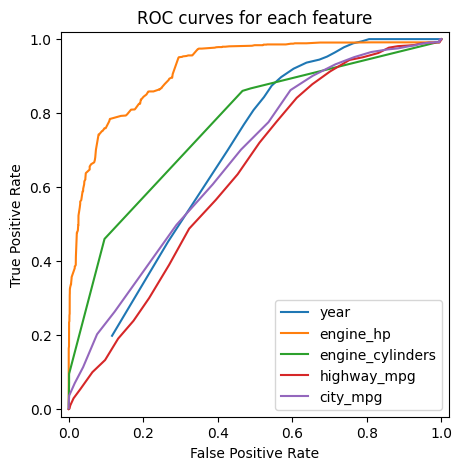

,Feature,AUC
1,engine_hp,0.92
2,engine_cylinders,0.77
0,year,0.68
4,city_mpg,0.67
3,highway_mpg,0.63


In [164]:
# Numerical features
mask = df.dtypes != object
numerical = list(df_train.dtypes[mask].index)


plt.figure(figsize=(5, 5))

# For each numerical feature, compute its importance and plot its ROC curve.
auc_dic = {}
for feature in numerical:
    current_auc, fpr, tpr, _, _ = roc_prec_recall(df_train[feature], Y_train)
    auc_dic[feature] = round(current_auc,2)
    plt.plot(fpr, tpr, label=f'{feature}')

# Setting the plot legend, limits, labels, and title.
plt.legend()
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for each feature')

plt.show()

# Convert the dictionary to a DataFrame
auc_df = pd.DataFrame(list(auc_dic.items()), columns=['Feature', 'AUC'])\
                                .sort_values(by='AUC', ascending=False)

display(auc_df)


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

In [165]:
train_dict = df_train.to_dict(orient = 'records')
val_dict = df_val.to_dict(orient = 'records')

# One-Hot encode
dv = DictVectorizer(sparse = False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

model = LogisticRegression(solver='liblinear',C = 1.0, max_iter=1000)
model.fit(X_train, Y_train)

# get predicted probabilities for the positive class
Y_pred_proba = model.predict_proba(X_val)[:, 1]

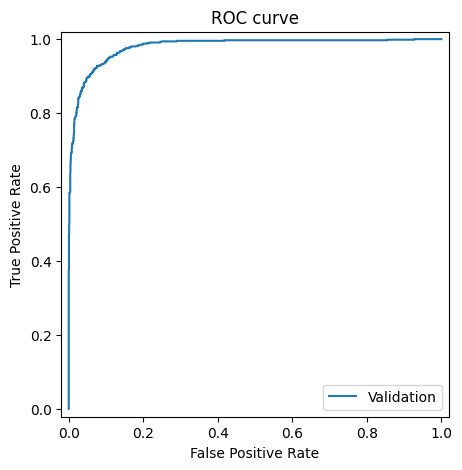

AUC = 0.98


In [166]:
plt.figure(figsize=(5, 5))
auc_value, fpr,tpr, __,_ = roc_prec_recall(Y_pred_proba, Y_val, feature_selection=False)
plt.plot(fpr, tpr, label=f'Validation')

# Settings
plt.legend()
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

plt.show()

print('AUC =', round(auc_value, 3) )

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

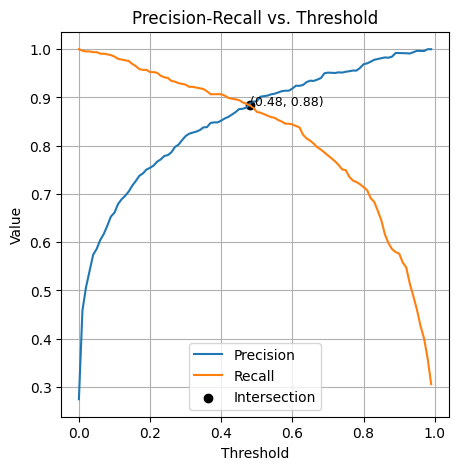

In [190]:
# Compute precision and recall using your function
thresholds = np.arange(0.0, 1.0 ,0.01)
_, _,_, precision, recall = roc_prec_recall(Y_pred_proba, Y_val, thresholds, feature_selection = False)

# Intersection point between precision and recall
intersect_point = np.abs(np.array(precision) - np.array(recall))
indice = np.argmin(intersect_point)
intersect_threshold =  thresholds[indice]
intersect_recall = recall[indice]

plt.figure(figsize=(5, 5))
_, _,_, precision, recall = roc_prec_recall(Y_pred_proba, Y_val, thresholds, feature_selection = False)
plt.plot(thresholds, precision, label=f'Precision')
plt.plot(thresholds, recall, label=f'Recall')
plt.scatter(intersect_threshold,intersect_recall, color = 'black', label='Intersection')
plt.text(intersect_threshold, intersect_recall, f'({intersect_threshold:.2f}, {intersect_recall:.2f})', color = 'black', fontsize=9)

# Settings
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.title('Precision-Recall vs. Threshold')
plt.grid(True)
plt.show()


### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F1 = \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}} = 2 \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

In [197]:
# Compute precision and recall using your function
thresholds = np.arange(0.0, 1.0, 0.01)
_, _, _, precision, recall = roc_prec_recall(Y_pred_proba, Y_val, thresholds, feature_selection=False)

# Compute F1 scores
precision = np.array(precision)
recall = np.array(recall)
F1 = 2 * (precision * recall) / (precision + recall)


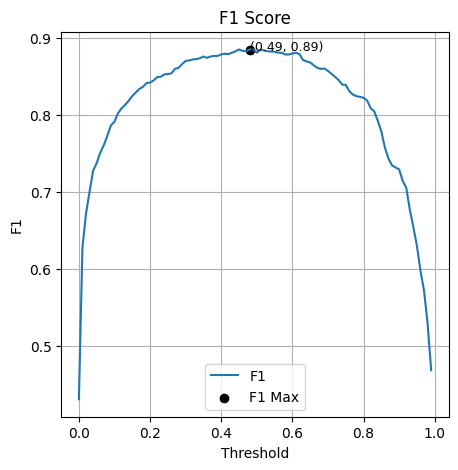

In [200]:
# Compute precision and recall using your function
thresholds = np.arange(0.0, 1.0, 0.01)
_, _, _, precision, recall = roc_prec_recall(Y_pred_proba, Y_val, thresholds, feature_selection=False)

# Compute F1 scores
precision = np.array(precision)
recall = np.array(recall)
F1 = 2 * (precision * recall) / (precision + recall)

# F1 maximum
indice = np.argmax(F1)
max_threshold = thresholds[indice]
max_f1 = F1[indice]

plt.figure(figsize=(5, 5))
plt.plot(thresholds, F1, label=f'F1')
plt.scatter(intersect_threshold,intersect_recall, color = 'black', label='F1 Max')
plt.text(intersect_threshold, intersect_recall, f'({max_threshold:.2f}, {max_f1:.2f})', color = 'black', fontsize=9)

# Settings
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('F1')
plt.title('F1 Score')
plt.grid(True)
plt.show()


**k-Fold Cross-Validation**

Cross-validation is a technique where we divide the dataset, $\mathbf{D}$, into $k$ parts of equal size, which we call folds (e.g., $\mathbf{D}_1,\mathbf{D}_2, \cdots, \mathbf{D}_k$). Each fold, $\mathbf{D}_i$, is used as a testing set one time, with the rest serving as the training set. 

To illustrate, consider we have a dataset and we choose $k=3$. The dataset is divided into 3 subsets or folds. In each iteration, we use one fold as the test set and the remaining folds as the training set, as show below:


<center><img src = "Images/k_fold_cv.png" width="400" height="200"/></center>


So in each iteration, the model is trained on the training set and its performance is evaluated on the testing set, $\mathbf{D}_i$, to obtain the $i^{th}$ estimate, $\theta_i$.

From there, we can estimate the average performance measure as:

$$\hat{\mu}_{\theta} = \mathbf{E}[\theta] = \frac{1}{k}\sum_{i=1}^{k}\theta_i$$ 

We can also calculate the variance of the performance measure as:

$$\hat{\sigma}_{\theta}^2 = \frac{1}{k}\sum_{i=1}^{k}(\theta_i -\hat{\mu}_{\theta})^2$$ 

The process starts by randomly shuffling the dataset, $\mathbf{D}$, then split it into $k$ equal parts. In each round of validation, one fold, $\mathbf{D}_i$, serves as the testing set, and the model's performance, $\theta_i$, is assessed. The process is repeated multiple times with different shuffles of the data to ensure the results are reliable.

Typically, we choose $k$ as either 5 or 10.

The Python code for implementing this process is as follows:

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

### Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.01, 0.1, 0.5, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?